In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [18]:
# 1. СОЗДАЕМ ИСКУССТВЕННУЮ ПОСЛЕДОВАТЕЛЬНОСТЬ
def generate_sequence(seq_length=500):
    """Генерация последовательности: смесь синуса и линейного тренда"""
    t = np.linspace(0, 20, seq_length)
    # Синусоида + линейный тренд + небольшой шум
    sequence = 2 * np.sin(1.5 * t) + 0.5 * t + 0.1 * np.random.randn(seq_length)
    return sequence

In [19]:
# Генерируем последовательность
full_sequence = generate_sequence(1000)
print(f"Длина последовательности: {len(full_sequence)}")
print(f"Первые 10 значений: {full_sequence[:10]}")

Длина последовательности: 1000
Первые 10 значений: [0.11319887 0.03449376 0.23536196 0.31964862 0.49440547 0.16765618
 0.48016748 0.50846356 0.56802883 0.55289382]


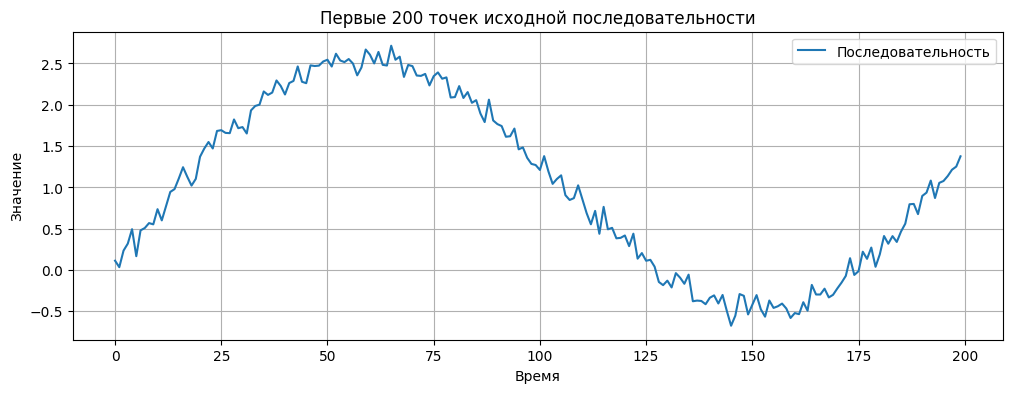

In [20]:
# Визуализируем
plt.figure(figsize=(12, 4))
plt.plot(full_sequence[:200], label='Последовательность')
plt.title('Первые 200 точек исходной последовательности')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

In [21]:

# 2. ПОДГОТОВКА ДАННЫХ ДЛЯ LSTM
def prepare_data(sequence, time_steps=10):
    """
    Подготовка данных для обучения LSTM
    sequence: исходная последовательность
    time_steps: сколько предыдущих значений использовать для предсказания
    Возвращает: X (признаки), y (целевые значения)
    """
    X, y = [], []
    for i in range(len(sequence) - time_steps - 1):
        # Берем time_steps предыдущих значений как контекст
        X.append(sequence[i:(i + time_steps)])
        # Следующее значение - это то, что мы хотим предсказать
        y.append(sequence[i + time_steps])
    
    return np.array(X), np.array(y)

In [22]:
# Параметры
TIME_STEPS = 20  # Сколько предыдущих значений смотрим
TEST_SIZE = 100  # Сколько точек оставляем для теста

# Подготовка данных
X, y = prepare_data(full_sequence, TIME_STEPS)

# Разделение на обучающую и тестовую выборки
split_idx = len(X) - TEST_SIZE
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nФормы данных:")
print(f"X_train: {X_train.shape}")  # (примеры, time_steps, 1 признак)
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


Формы данных:
X_train: (879, 20)
y_train: (879,)
X_test: (100, 20)
y_test: (100,)


In [23]:
# LSTM ожидает 3D данные: [samples, time_steps, features]
# У нас пока 2D, нужно добавить измерение признаков
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\nПосле преобразования:")
print(f"X_train: {X_train.shape}")  # (примеры, time_steps, 1 признак)


После преобразования:
X_train: (879, 20, 1)


In [24]:
# 3. СОЗДАНИЕ МОДЕЛИ LSTM
model = keras.Sequential([
    # Явно указываем входной слой
    layers.Input(shape=(TIME_STEPS, 1)),
    
    # Первый LSTM слой с возвратом последовательности
    layers.LSTM(50, activation='tanh', return_sequences=True),
    layers.Dropout(0.2),
    
    # Второй LSTM слой
    layers.LSTM(50, activation='tanh', return_sequences=False),
    layers.Dropout(0.2),
    
    # Полносвязные слои
    layers.Dense(25, activation='relu'),
    layers.Dense(1)  # Предсказание одного значения
])

# Компиляция модели
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Среднеквадратичная ошибка для регрессии
    metrics=['mae']  # Средняя абсолютная ошибка
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# 4. ОБУЧЕНИЕ МОДЕЛИ
print("\nНачинаем обучение...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,  # 10% обучающих данных для валидации
    verbose=1
)


Начинаем обучение...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 22.5315 - mae: 4.0425 - val_loss: 42.8283 - val_mae: 6.3979
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.2470 - mae: 1.8336 - val_loss: 17.9961 - val_mae: 4.0274
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8158 - mae: 0.9804 - val_loss: 6.3542 - val_mae: 2.1942
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4156 - mae: 0.4805 - val_loss: 2.9589 - val_mae: 1.3933
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3241 - mae: 0.4211 - val_loss: 2.8796 - val_mae: 1.4831
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3007 - mae: 0.3994 - val_loss: 2.2280 - val_mae: 1.2416
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2644 - mae: 0.3805 - val_loss: 1.6984 - val_mae: 1.0242
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2183 - mae: 0.3575 - val_loss: 1.6548 - val_mae: 1.0322
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1

In [26]:
# 5. ОЦЕНКА МОДЕЛИ
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"\nРезультаты обучения:")
print(f"Обучающая выборка - MSE: {train_loss:.4f}, MAE: {train_mae:.4f}")
print(f"Тестовая выборка - MSE: {test_loss:.4f}, MAE: {test_mae:.4f}")


Результаты обучения:
Обучающая выборка - MSE: 0.1180, MAE: 0.1888
Тестовая выборка - MSE: 0.5996, MAE: 0.6021


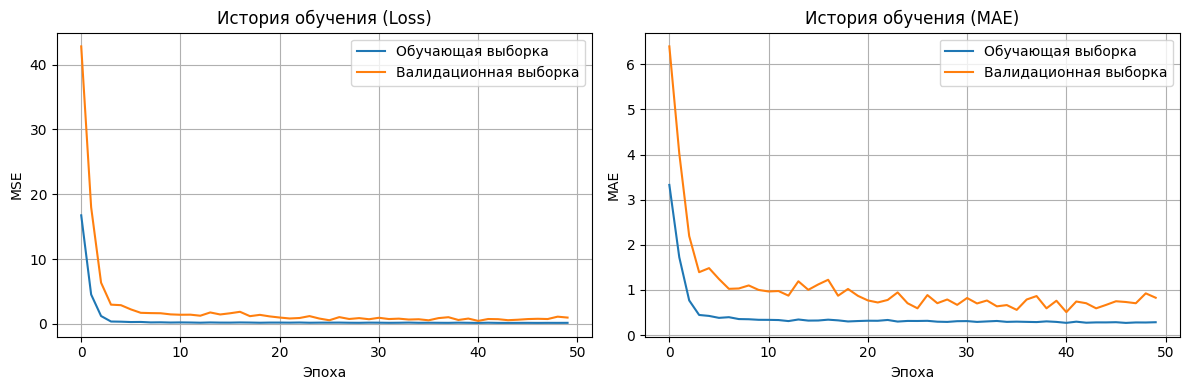

In [27]:
# 6. ВИЗУАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Валидационная выборка')
plt.title('История обучения (Loss)')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Обучающая выборка')
plt.plot(history.history['val_mae'], label='Валидационная выборка')
plt.title('История обучения (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


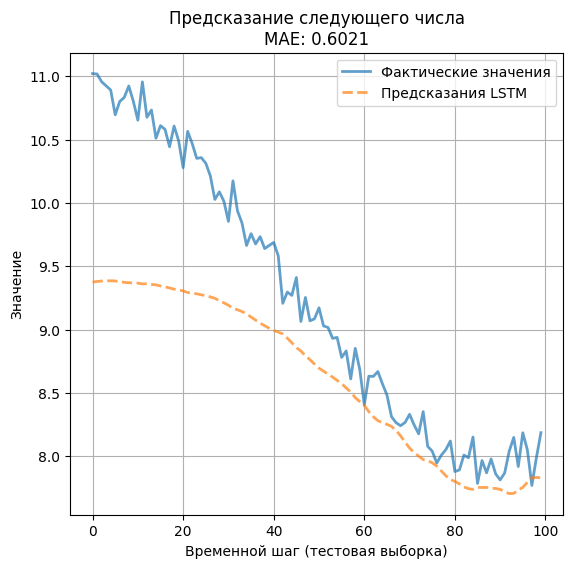

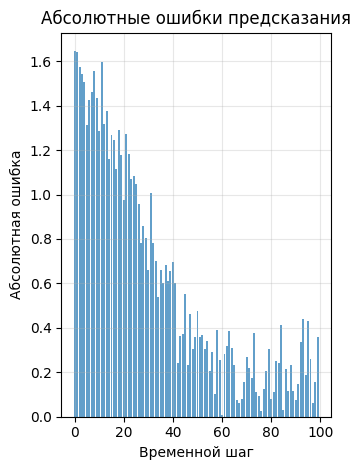

In [28]:
# 7. ПРОГНОЗИРОВАНИЕ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# Делаем предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Визуализируем результаты
plt.figure(figsize=(14, 6))

# График 1: Предсказания vs Фактические значения
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Фактические значения', alpha=0.7, linewidth=2)
plt.plot(y_pred, label='Предсказания LSTM', alpha=0.7, linestyle='--', linewidth=2)
plt.title(f'Предсказание следующего числа\nMAE: {test_mae:.4f}')
plt.xlabel('Временной шаг (тестовая выборка)')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

plt.show()

# График 2: Ошибки предсказания
plt.subplot(1, 2, 2)
errors = np.abs(y_test.flatten() - y_pred.flatten())
plt.bar(range(len(errors)), errors, alpha=0.7)
plt.title('Абсолютные ошибки предсказания')
plt.xlabel('Временной шаг')
plt.ylabel('Абсолютная ошибка')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# 8. ФУНКЦИЯ ДЛЯ ИНТЕРАКТИВНОГО ПРЕДСКАЗАНИЯ
def predict_next(model, last_sequence, time_steps):
    """
    Предсказание следующего значения на основе последних time_steps значений
    """
    # Подготавливаем входные данные
    input_seq = np.array(last_sequence[-time_steps:]).reshape(1, time_steps, 1)
    
    # Делаем предсказание
    prediction = model.predict(input_seq, verbose=0)
    
    return prediction[0, 0]

In [30]:
# Демонстрация: предсказываем несколько следующих значений
print("\n" + "="*60)
print("ДЕМОНСТРАЦИЯ: ПРЕДСКАЗАНИЕ БУДУЩИХ ЗНАЧЕНИЙ")
print("="*60)

# Берем последние TIME_STEPS значений из тестовой выборки
last_known = X_test[0].flatten().tolist()
print(f"\nПоследние {TIME_STEPS} известных значений:")
for i, val in enumerate(last_known):
    print(f"  t-{TIME_STEPS-i}: {val:.4f}")

# Фактическое следующее значение (которое модель пытается угадать)
actual_next = y_test[0]
print(f"\nФактическое следующее значение: {actual_next:.4f}")

# Предсказываем
predicted = predict_next(model, last_known, TIME_STEPS)
print(f"Предсказанное LSTM значение: {predicted:.4f}")
print(f"Ошибка: {abs(actual_next - predicted):.4f}")


ДЕМОНСТРАЦИЯ: ПРЕДСКАЗАНИЕ БУДУЩИХ ЗНАЧЕНИЙ

Последние 20 известных значений:
  t-20: 10.7502
  t-19: 10.6792
  t-18: 10.6479
  t-17: 10.7694
  t-16: 10.6721
  t-15: 10.6192
  t-14: 10.8018
  t-13: 10.8049
  t-12: 10.7603
  t-11: 10.8564
  t-10: 10.9430
  t-9: 10.8339
  t-8: 10.9186
  t-7: 10.8874
  t-6: 10.8264
  t-5: 10.9113
  t-4: 11.1111
  t-3: 10.7945
  t-2: 10.9187
  t-1: 11.0601

Фактическое следующее значение: 11.0224
Предсказанное LSTM значение: 9.3757
Ошибка: 1.6467
